# Evaluating Probabilistic Forecasts

### Objectives

In this part, we will explore ways to investigate forecasts to analyze their quality. This part of the workshop builds upon what was being discussed in the previous notebook on *"Practical Application of Probabilistic Forecasting"*, so little explanation is given about how to use the [`darts`](https://unit8co.github.io/darts/index.html) library to generate various types of forecasts.

### Structure of the Notebook 

This notebook is set up in a sequential way. The first cells take care of *setting up the code environment* by importing the required cells. Then, the *data* necessary to introduce the concepts of forecast evaluation are prepared by generating sample forecasts. This is followed by the core content of the notebook in which an introduction into *point forecast evaluation* is given first, and *probabilistic forecast evaluation* is given second.

**Notebook Chapters:**

1. Code Setup
2. Data Preparation
3. Evaluating Point Forecasts
4. Evaluating Probabilistic Forecasts

### 1. Code Setup

In the following cell, the Python environment to be used is initialized by importing the required packages. Please make sure that you have the required packages installed. All of them can easily be installed via [pip](https://pypi.org/) (e.g., `pip install darts`).

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from darts import TimeSeries
from darts.metrics import rho_risk
from darts.models import ExponentialSmoothing, NBEATSModel
from darts.utils.likelihood_models import QuantileRegression

# Beautify plotting
sns.set_theme(style="whitegrid", palette="colorblind")

### 2. Data Preparation

The next handful of cells prepares the data to be used in the remainder of the notebook. In particular, we will load the raw source data and preprocess it in the same way preprocessing was handled in the notebook *"Practical Application of Probabilistic Forecasting"*, split it into train and test datasets, and generate sample forecasts.

**Please make sure that you understand what is happening in here, since you can use some of the variables in the assignments below.**

In [10]:
# --- PREP -----------------------------------------------------------------------------------------
# Load the true data points and preprocess them by renaming columns, extracting the drug group of
# interest, and converting the data to a time series.
# --------------------------------------------------------------------------------------------------

# Load raw source data
df_raw = pd.read_csv("salesweekly.csv", parse_dates=["datum"])

# Turn data into long format
df_melted = df_raw.melt(id_vars="datum", var_name="unique_id", value_name="sold_qty")

# Extract the drug group of interest
drug_group = "R06"
df = df_raw[["datum", drug_group]].reset_index(drop=True).copy()
df = df.rename(columns={"datum": "date", drug_group: "sold_qty"})
df.insert(1, "unique_id", drug_group)
df = df.sort_values(by="date")
df["date"] = pd.to_datetime(df["date"])
display(df.head())

# Turn to time series and split train/test
ts = TimeSeries.from_dataframe(df, "date", "sold_qty")
train, test = ts.split_before(pd.Timestamp("20190101"))

# Type conversions to avoid Mac issues
train = train.astype(np.float32)
test = test.astype(np.float32)

,date,unique_id,sold_qty
0,2014-01-05,R06,7.0
1,2014-01-12,R06,7.2
2,2014-01-19,R06,12.0
3,2014-01-26,R06,10.0
4,2014-02-02,R06,12.0


In [1]:
# --- PREP -----------------------------------------------------------------------------------------
# Generate sample forecasts using darts (pred_*_prob). Also prepare matrix representations of the
# forecasts for further processing and evaluation (pred_*_prob_vals).
# --------------------------------------------------------------------------------------------------

# Generate the Exponential Smoothing forecast
model_es_prob = ExponentialSmoothing()
model_es_prob.fit(train)
pred_es_prob = model_es_prob.predict(41, num_samples=100)
pred_es_prob_vals = pred_es_prob.all_values().reshape(-1, 100)

# Generate the NBEATS forecast
model_nbeats_prob = NBEATSModel(input_chunk_length=52, output_chunk_length=4, likelihood=QuantileRegression())
model_nbeats_prob.fit(train, epochs=5, verbose=True)
pred_nbeats_prob = model_nbeats_prob.predict(41, num_samples=100)
pred_nbeats_prob_vals = pred_nbeats_prob.all_values().reshape(-1, 100)

NameError: name 'ExponentialSmoothing' is not defined

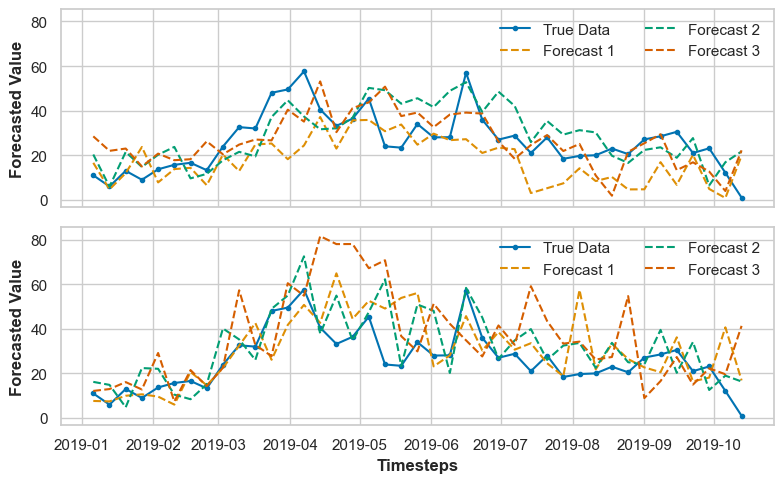

In [12]:
# --- ASSIGNMENT -----------------------------------------------------------------------------------
# Visualization of the data to get an understanding of what we are working with.
#
# 1. Plot the true data.
# 2. Plot the first three sample forecasts from pred_es_prob on top of the true data.
# 3. Create a second plot, visualizing the true data and pred_nbeats_prob.
# --------------------------------------------------------------------------------------------------

# Setup plotting
fig, axs = plt.subplots(2, 1, figsize=(8, 5), sharey=True)

# Plot the true data
axs[0].plot(test.time_index, test.values().flatten(), marker=".", color="C0", label="True Data")
axs[1].plot(test.time_index, test.values().flatten(), marker=".", color="C0", label="True Data")

# Plot predictions
for idx in range(1,4):
    axs[0].plot(pred_es_prob.time_index, pred_es_prob_vals[:, idx], ls="--", color=f"C{idx}", label=f"Forecast {idx}")
    axs[1].plot(pred_nbeats_prob.time_index, pred_nbeats_prob_vals[:, idx], ls="--", color=f"C{idx}", label=f"Forecast {idx}")

axs[0].legend(ncols=2)
axs[0].set_ylabel("Forecasted Value")
axs[0].set_xticklabels([])

axs[1].legend(ncols=2)
axs[1].set_xlabel("Timesteps")
axs[1].set_ylabel("Forecasted Value")

plt.tight_layout()
plt.show()

**End of Data Preparation**

We have now

- Loaded and preprocessed the true data of interest
- Generated sample forecasts that look reasonable and can be used to investigate forecast performances
- Gotten an understanding of the data and variables we will be working with

Next, we will look into evaluating forecast quality.

---

### 3. Evaluating Point Forecasts

Performance evaluation is a core concept of modeling. Regardless of whether we are building regression models, classification models, or forecasts, we cannot even think about putting them into practice if we do not have an intuition about whether they will perform well or not.

Usually, performance is evaluated by comparing a true signal $y$ with a predicted signal $\hat{y}$. If the deviation between the two is small and the data we are evaluating the performance on is a reasonable representation of the future application scenario, our trust in the generalization capabilities of the model increases.

In forecasting, the general concept of evaluation is similar to that. Ideally, we have a known test time series of length $T$ consisting of individual data points $y_t$ where $1 \leq t \leq T$, and a forecast time series $\hat{y}_t$ of the same length. If we want to evaluate the performance, we compare $y_t$ with $\hat{y}_t$ and aggregate (e.g., by calculating the average) the individual comparisons throughout time to get a performance or error score for the forecast.

*Further Reading:*

- Gneiting (2011). Making and Evaluating Point Forecasts
- Petropopulos et al. (2022). Forecasting: theory and practice

**Examples of Error Metrics**

Given a true time series $y_t$ of length $T$ and predictions $\hat{y}_t$ with $1 \leq t \leq T$:

- [Mean Absolute Error (MAE)](https://unit8co.github.io/darts/generated_api/darts.metrics.metrics.html#darts.metrics.metrics.mae):

    $\text{MAE} = \frac{1}{T}\sum\limits_{t=1}^T(|\hat{y}_t - y_t|)$

- [Mean Squared Error (MSE)](https://unit8co.github.io/darts/generated_api/darts.metrics.metrics.html#darts.metrics.metrics.mse)

    $\text{MSE} = \frac{1}{T}\sum\limits_{t=1}^T(\hat{y}_t - y_t)^2$

- [Mean Absolute Percentage Error (MAPE)](https://unit8co.github.io/darts/generated_api/darts.metrics.metrics.html#darts.metrics.metrics.mape):

    $\text{MAPE} = 100 \cdot\frac{1}{T}\sum\limits_{t=1}^T |\frac{y_t-\hat{y}_t}{y_t}|$

- [And many more...](https://unit8co.github.io/darts/generated_api/darts.metrics.metrics.html)

**-> Lets see it in action!**

In [13]:
# --- ASSIGNMENT -----------------------------------------------------------------------------------
# Implement the error metrics according to the definitions above.
#
# 1. Implement the Mean Absolute Error (MAE) function.
# 2. Implement the Mean Squared Error (MSE) function.
# 3. Implement the Mean Absolute Percentage Error (MAPE) function.
# --------------------------------------------------------------------------------------------------

def mae(actual, prediction):
    return np.mean(np.abs(actual - prediction))

def mse(actual, prediction):
    return np.mean((actual - prediction)**2)

def mape(actual, prediction):
    return np.mean(np.abs((actual - prediction) / actual)) * 100


Forecast 1: MAE=11.4470	MSE=208.8013	MAPE=88.8137
Forecast 2: MAE=9.3446	MSE=126.2585	MAPE=87.7798
Forecast 3: MAE=8.9090	MSE=128.8718	MAPE=92.5977
best=15 (76.1099) worst=7 (393.7128)


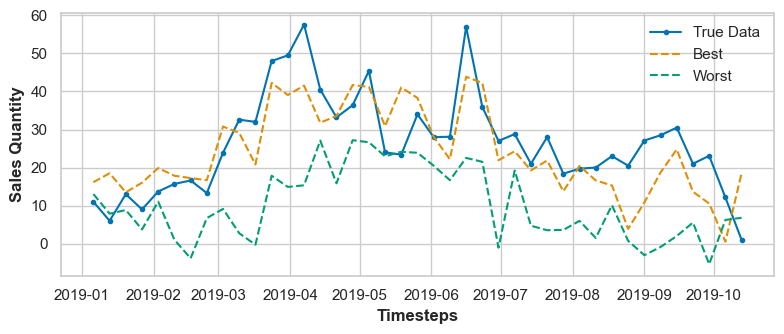

In [14]:
# --- ASSIGNMENT -----------------------------------------------------------------------------------
# Let's assume for the sake of this exercise that the forecast samples from pred_es_prob  are
# resulting from different forecasting models. Let's also assume that time advanced and we can now
# compare the forecasts with the actual data that came to realize.
#
# 1. Compute the forecast performances for the three forecasts (pred_es_prob_vals column indices
#    [1, 2, 3]) for the error metrics defined above. Make sure to use the actual realizations from
#    the test data. Which of the three forecasts performed best?
# 2. Find the overall best and overall worst forecasts from pred_es_prob_vals according to MSE and
#    plot them together with the true data.
# --------------------------------------------------------------------------------------------------

# Extract actual data for ease of use
actual_data = test.values().flatten()

# Compute error metrics for first three forecasts
for idx in range(1,4):
    forecast = pred_es_prob_vals[:, idx]
    error_mae = mae(actual_data, forecast)
    error_mse = mse(actual_data, forecast)
    error_mape = mape(actual_data, forecast)
    print(f"Forecast {idx}: MAE={error_mae:.4f}\tMSE={error_mse:.4f}\tMAPE={error_mape:.4f}")

# Find the overall best and overall worst forecasts according to MAPE
errors = []
for forecast in pred_es_prob_vals.T:
    errors.append(mse(actual_data, forecast))

# Identify best and worst forecasts
idx_best = np.argmin(errors)
idx_worst = np.argmax(errors)
best = pred_es_prob_vals[:, idx_best]
worst = pred_es_prob_vals[:, idx_worst]
print(f"best={idx_best} ({errors[idx_best]:.4f}) worst={idx_worst} ({errors[idx_worst]:.4f})")

# Plot forecasts and actual data
plt.figure(figsize=(8, 3.5))
plt.plot(test.time_index, test.values().flatten(), marker=".", label="True Data")
plt.plot(pred_es_prob.time_index, best, ls="--", label="Best")
plt.plot(pred_es_prob.time_index, worst, ls="--", label="Worst")
plt.legend()
plt.xlabel("Timesteps")
plt.ylabel("Sales Quantity")
plt.tight_layout()
plt.show()

**Results Assignment Part 1**

- Out of the first 3 forecasts, Forecast 3 is the best according to MAE and MSE
- Out of the first 3 forecasts, Forecast 1 is best according to MAPE
- Intuition would agree that Forecast 3 is best (visual inspection above)

**Results Assignment Part 2**

- Forecast 15 is the overall best according to MSE
- Forecast 7 is the overall worst according to MSE
- Difference in performance is very apparent in the plot visualization

**Notes about Metric-Based Performance Evaluation**

- There exist many metrics for calculating performance scores
- As in other modeling problems (e.g., classification or regression), the choice of metric should be tightly linked to the practical problem at hand

**-> Now what can we do if we do not have an easy-to-handle series of values but a distribution as in the case of probabilistic forecasts?**

---

### 4. Evaluating Probabilistic Forecasts

In point forecasts, the problem of evaluation could be tackled via straight-forward comparisons of the true data sequence and the forecasted data sequence. This could be done trivial, because the forecast was of the same form than the true data - a sequence of values. Evaluating probabilistic forecasts is significantly more challenging because we are not handling a simple sequence but a sequence of probability distribution. What makes matters worse, in most practical problems we do not even have an analytical definition of the probability distributions, just like in the Monte Carlo forecasts we generated above.

So what can we do to overcome these hurdles? Evaluating probabilistic forecasts is a domain that is still heavily debated in the literature. In the following we will embark on some first steps towards gaining intuition about the quality of probabilistic forecasts.

##### 4.1 Extracting Point Forecasts from Probabilistic Forecasts

One approach of making probabilistic forecasts more accessible is to reduce them to point forecasts. This is akin to adopting a scenario-based perspective. For example, we can investigate worst case scenarios by looking at the points in the distributions below which 10% (negative case) or 90% (positive case) of the Monte Carlo samples fall. This approach is one that is often taken to share results and insight from probabilistic forecasts and is built into common forecasting solutions like [AWS Forecast](https://aws.amazon.com/blogs/machine-learning/amazon-forecast-now-supports-the-generation-of-forecasts-at-a-quantile-of-your-choice/).

Let's explore this in practice!

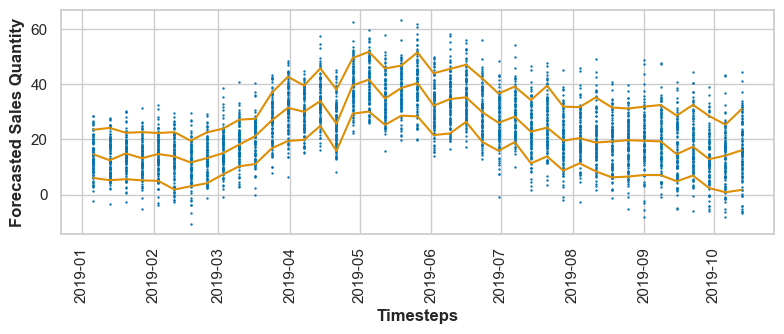

In [15]:
# --- ASSIGNMENT -----------------------------------------------------------------------------------
# As a first step towards understanding the quality of probabilistic forecasts, let's take
# another look at what the forecast data actually represents.
#
# 1. Plot the data from pred_es_prob_vals as a scatter plot, where each forecasted value is
#    represented as an individual point.
# 2. Extract quantiles, i.e., the points blow which X% of the forecasted values fall, from the
#    probabilistic forecast data and add the 10%, 50%, and 90% quantile curves to the same plot.
#    Quantiles can be extracted via the quantile function from numpy.
# --------------------------------------------------------------------------------------------------

plt.figure(figsize=(8, 3.5))

# Plot forecasted data
timesteps = pred_es_prob.time_index.values
for idx, ts_samples in enumerate(pred_es_prob_vals):
    plt.scatter([timesteps[idx]] * len(ts_samples), ts_samples, color="C0", s=0.5)

# Extract and plot quantiles
target_quantiles = [0.1, 0.5, 0.9]
quantile_data = np.quantile(pred_es_prob_vals, target_quantiles, axis=1)
for idx, quantile in enumerate(quantile_data):
    plt.plot(timesteps, quantile, label=f"{target_quantiles[idx]*100}%", color="C1")

plt.xticks(rotation=90)
plt.xlabel("Timesteps")
plt.ylabel("Forecasted Sales Quantity")
plt.tight_layout()
plt.show()

**Results**

- The quantile curves provide an easy-to-grasp overview about how the probability mass is distributed at every point in time
- Often, quantile curves are passed on to various business functions to perform planning and decision-making tasks
- The point forecasts, e.g., the median, i.e., the 50% quantile, can then be compared with the true data just like we did above

##### Sharpness

The drawback of considering point forecast reductions from probabilistic forecasts is that we neglect the distributional information we have. On a very basic level, the spread reflects uncertainty, information that should not be ignored for evaluative purposes.

The property providing information about the uncertainty of the forecast is called *sharpness*. Sharpness can be defined by the distance between two quantiles of the forecast distribution, e.g., the distance between the 5th and 95th percentile. The bigger the distance, the more uncertainty resides in the forecast, and the less usable the forecast is for precise planning and decision-making purposes. The goal of forecasting thus is to find a forecast that is unbiased and as sharp as possible!

Let's explore the concept of sharpness in practice!

*Further Reading:*

- Bremnes (2004). Probabilistic Forecasts of Precipitation in Terms of Quantiles Using NWP Model Output
- Bremnes (2004). Probabilistic Wind Power Forecasts Using Local Quantile Regression
- Gneiting et al. (2007). Probabilistic forecasts, calibration and sharpness
- Petropoulos et al. (2022). Forecasting: theory and practice


ES    : 26.96224689192179
NBEATS: 37.3006555193808


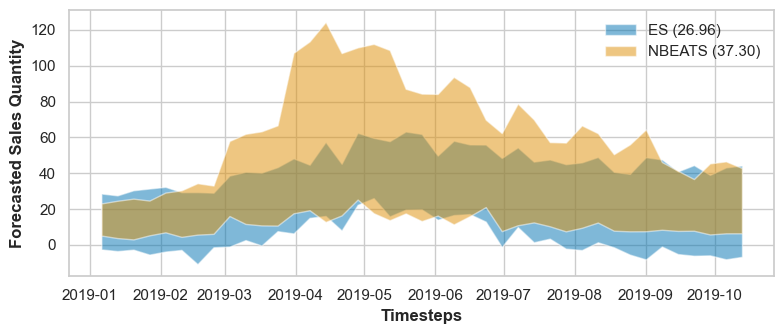

In [16]:
# --- ASSIGNMENT -----------------------------------------------------------------------------------
# 1. Implement the sharpness metric and compute it for pred_es_prob and pred_nbeats_prob.
# 2. Visualize the spread of both probabilistic forecasts.
# 3. Compare the sharpness values with the visualizations. Observe the spread of the distributions
#    and how they relate to sharpness.
# --------------------------------------------------------------------------------------------------

def sharpness(forecast_data, quantile_low=0.05, quantile_high=0.95):
    q_low = np.quantile(forecast_data, quantile_low, axis=1)
    q_high = np.quantile(forecast_data, quantile_high, axis=1)
    return np.mean(q_high - q_low)

# Sharpness for the probabilistic forecasts
es_sharpness = sharpness(pred_es_prob.all_values().reshape(-1, 100))
nbeats_sharpness = sharpness(pred_nbeats_prob.all_values().reshape(-1, 100))
print("ES    :", es_sharpness)
print("NBEATS:", nbeats_sharpness)

# Visualize the spread of the probabilistic forecasts
plt.figure(figsize=(8, 3.5))

es_mins = pred_es_prob_vals.min(axis=1)
es_maxs = pred_es_prob_vals.max(axis=1)
plt.fill_between(pred_es_prob.time_index, es_mins, es_maxs, alpha=0.5, label=f"ES ({es_sharpness:.2f})")

nbeats_mins = pred_nbeats_prob_vals.min(axis=1)
nbeats_maxs = pred_nbeats_prob_vals.max(axis=1)
plt.fill_between(pred_nbeats_prob.time_index, nbeats_mins, nbeats_maxs, alpha=0.5, label=f"NBEATS ({nbeats_sharpness:.2f})")

plt.xlabel("Timesteps")
plt.ylabel("Forecasted Sales Quantity")

plt.legend()
plt.tight_layout()
plt.show()

##### Scoring Rules

Finally, we need to find a way to understand whether the forecast is unbiased. One way to check this is via so-called *scoring rules*, which are very similar to the error metrics we saw for the point forecasting case. Whereas in the point forecasting case, we spoke about metrics defined as $s(y, \hat{y})$ comparing a true data point $y$ with forecast $\hat{y}$, we are now looking for metrics defined as $s(y, F)$, i.e., comparing a true data point $y$ with a forecast distribution $F$.

Since the definition and derivation of scoring rules for probabilistic forecasts is out of scope for this workshop, we leave interested readers with pointers to the relevant literature and focus on applying one ready-to-use scoring rule, the Rho-Risk or Quantile Risk, for demonstration purposes below.

**Examples of Scoring Rules:**

- Rho-Risk or Quantile Risk, e.g., as implemented in [`darts`](https://unit8co.github.io/darts/generated_api/darts.metrics.metrics.html#darts.metrics.metrics.rho_risk)
- Continuous Ranked Probability Score (CRPS), e.g., as implemented in [pyro](https://docs.pyro.ai/en/stable/ops.html#pyro.ops.stats.crps_empirical))

*Further Reading:*

- Gneiting (2011). Quantiles as optimal point forecasts
- Gneiting et al. (2007). Probabilistic forecasts, calibration and sharpness
- Petropoulos (2022). Forecasting: theory and practice
- Salinas et al. (2020). DeepAR: Probabilistic forecasting with autoregressive recurrent networks

In [17]:
# --- ASSIGNMENT -----------------------------------------------------------------------------------
# Compute rho_risk for pred_es_prob and pred_nbeats_prob with rho=0.1, rho=0.5, and rho=0.9 to
# figure out which probabilistic forecast is more robust to under- or overestimation.
# --------------------------------------------------------------------------------------------------

rhos = [0.1, 0.5, 0.9]
for rho in rhos:
    print(f"ES     (rho={rho}):", rho_risk(actual_series=test, pred_series=pred_es_prob, rho=rho))
    print(f"NBEATS (rho={rho}):", rho_risk(actual_series=test, pred_series=pred_nbeats_prob, rho=rho))

ES     (rho=0.1): 0.07726339004613593
NBEATS (rho=0.1): 0.1724977485014367
ES     (rho=0.5): 0.13013705926437283
NBEATS (rho=0.5): 0.24549507706299006
ES     (rho=0.9): 0.029898870999243845
NBEATS (rho=0.9): 0.08043138146061142


**Results:**

- ES has the lower, i.e., better rho-risk score across the different values of rho
- ES also had a better sharpness
- Thus, ES should be considered the better forecast

---

### Summary of Evaluation of Forecasts

- We have seen that the evaluation of point forecasts can be tackled quite straight-forwardly
    - Error metrics are easy to define and easy to evaluate
    - There are many general-purpose error metrics with different properties to fit different problems' needs
    - Error metrics can be fine-tuned to the problem at hand
- The evaluation of probabilistic forecasts is trickier
    - Often there is no analytical way of computing forecast performance based on the exact probability distributions
    - One way to circumvent this issue is to draw insight from multiple angles of inspection, both visually and via calculations
    - Sharpness and scoring rules provide a good overview about properties of the forecast and about which forecast should be preferred

**-> What are the implications of forecast quality on real-world problems?**